In [16]:
import colorlover as cl
import ast
import jenkspy
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
from matplotlib import collections as mc
from matplotlib import cm
import pandas as pd
import datetime
import numpy as np
import copy
from sklearn import linear_model
%aimport BEP_PM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
log = importer.apply('Road_Traffic_Fine_Management_Process.xes')
print('Done importing')
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', log, resource_id='org:resource')
pf = pd.concat([pd.DataFrame(rf.log[i]) for i in range(len(rf.log))], sort=False)
pf.loc[pf.index == 0, 'case_id'] = [i for i in range((pf.index == 0).sum())]
pf['case_id'] = pf['case_id'].fillna(method='ffill')

KeyboardInterrupt: 

In [ ]:
df = pf[['concept:name', 'time:timestamp', 'case_id', 'org:resource']].copy()
df.columns = ['segment_name', 'end_time', 'case_id', 'resource']

In [5]:
df['end_time'] = df['end_time'] - rf.first
df['end_time']  = df['end_time'].dt.days

In [6]:
rf.pf = df.sort_values('case_id').copy()
rf.pf['resource'] = rf.pf['resource'].fillna(method='ffill')

In [7]:
t = rf.pf.sort_values(['resource', 'end_time']).reset_index(drop=True)
t['predicted_start'] = t.shift()[t.shift()['resource'] == t['resource']]['end_time']
rf.pf = t.sort_values('case_id')
rf.pf['duration'] = rf.pf['end_time'] - rf.pf['predicted_start']

In [8]:
t = rf.pf.sort_values(['case_id','end_time']).copy()
t_s = rf.pf.sort_values(['case_id','end_time']).shift(-1).copy()
shelve_begin = t[t['case_id'] == t_s['case_id']][['segment_name', 'end_time', 'case_id', 'resource']]
shelve_begin.columns = ['segment_start', 'predicted_start', 'case_id', 'resource_start']
shelve_begin.reset_index(drop=True, inplace=True)

In [9]:
shelvetimes = t_s[t_s['case_id'] == t['case_id']][['predicted_start', 'resource', 'segment_name']]
shelvetimes.columns = ['end_time', 'resource_end', 'segment_end']
shelvetimes.reset_index(drop=True, inplace=True)

In [10]:
new = pd.concat([shelve_begin, shelvetimes], axis=1)
new['segment_name'] = new['segment_start'] + '-' + new['segment_end']
new['duration'] = new['end_time'] - new['predicted_start']
new['shelve'] = True
rf.pf = rf.pf.append(new)

In [11]:
rf.segments = ['Create Fine',
 'Create Fine-Send Fine',
 'Create Fine-Payment',
 'Payment',
 'Send Fine',
 'Send Fine-Insert Fine Notification',
 'Insert Fine Notification',
 'Insert Fine Notification-Add penalty',
 'Add penalty',
 'Add penalty-Payment',
 'Add penalty-Send for Credit Collection',
 'Send for Credit Collection']

In [12]:
rf.pf = rf.pf[rf.pf['segment_name'].isin(rf.segments)]
rf.pf['segment_index'] = rf.pf['segment_name'].apply(lambda x: list(rf.segments).index(x))

In [13]:
rf.pf['start_y'] = (200//len(rf.segments))*(len(rf.segments)-rf.pf['segment_index'])
rf.pf['end_y'] = rf.pf['start_y'] - (200//len(rf.segments))
rf.y_s = [[y, y - (200//len(rf.segments))] for y in range((200//len(rf.segments)) * len(rf.segments), 0, -(200//len(rf.segments)))]

In [14]:
rf.pf = rf.pf[~rf.pf['predicted_start'].isna()]
rf.pf = rf.pf[rf.pf['duration'] > 0]

# Quick load

In [18]:
log = importer.apply('Road_Traffic_Fine_Management_Process.xes')
print('Done importing')
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', log, resource_id='org:resource')
rf.pf = pd.read_csv('C:/Users/20173939/Documents/Study/BEP/roadfines.txt')
rf.segments = ['Create Fine Start - Complete',
 'Create Fine Complete - Send Fine Start',
 'Create Fine Complete - Payment Start',
 'Payment Start - Complete',
 'Send Fine Start - Complete',
 'Send Fine Complete - Insert Fine Notification Start',
 'Insert Fine Notification Start - Complete',
 'Insert Fine Notification Complete - Add penalty Start',
 'Add penalty Start - Complete',
 'Add penalty Complete - Payment Start',
 'Add penalty Complete - Send for Credit Collection Start',
 'Send for Credit Collection']
rf.y_s = [[y, y - (200//len(rf.segments))] for y in range((200//len(rf.segments)) * len(rf.segments), 0, -(200//len(rf.segments)))]

Done importing


c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Full default performance spectrum:

(-60.0, 1000.0)

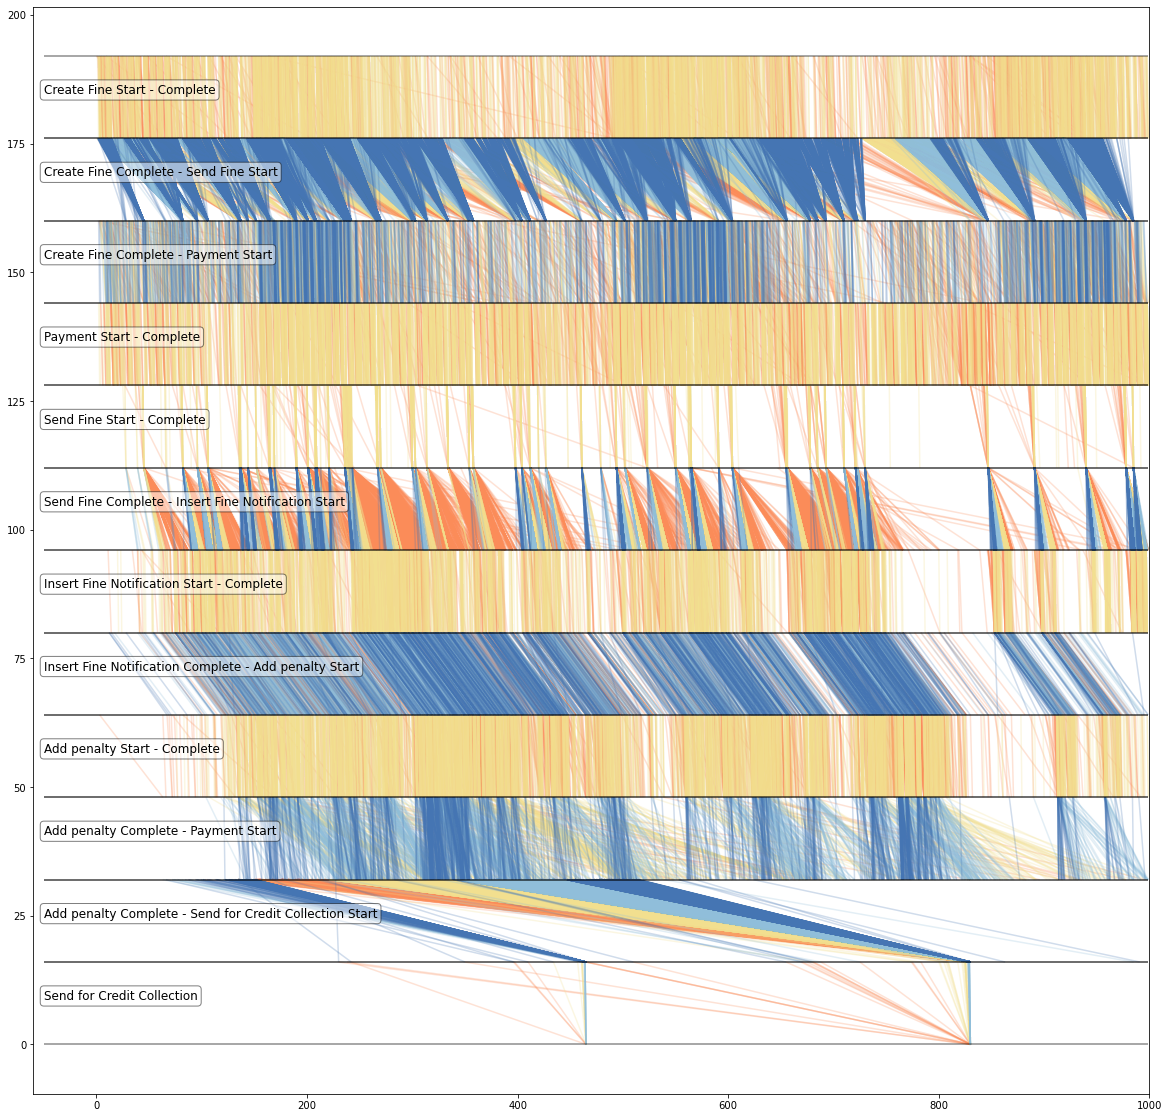

In [19]:
rf.classify(rf.pf, rf.classify_duration_hist, metric='duration', args=[4], inplace=True)
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
rf.plot_performance_spectrum(class_colors, ax, start='predicted_start', mask=rf.pf['end_time'] < 1000, label_offset=-50)
plt.xlim([-60,1000])

# New workload

In [20]:
rf.pf

,Unnamed: 0,segment_name,end_time,case_id,resource,predicted_start,duration,segment_start,resource_start,resource_end,...,segment_index,start_y,end_y,class,end_interval,start_interval,que_class,load_class,global que_class,global load_class
0,391410,Create Fine,2396.0,0.0,561.0,2395.0,1.0,NaN,NaN,NaN,...,0,192,176,2.0,342.0,342.0,0.0,0.0,NaN,NaN
1,392622,Send Fine,2530.0,0.0,561.0,2529.0,1.0,NaN,NaN,NaN,...,4,128,112,2.0,361.0,361.0,2.0,2.0,NaN,NaN
2,392705,Send Fine,2537.0,1.0,561.0,2536.0,1.0,NaN,NaN,NaN,...,4,128,112,2.0,362.0,362.0,2.0,2.0,3.0,2.0
3,399227,Send for Credit Collection,3376.0,1.0,561.0,3375.0,1.0,NaN,NaN,NaN,...,11,16,0,1.0,482.0,482.0,0.0,0.0,3.0,2.0
4,391475,Create Fine,2405.0,1.0,561.0,2404.0,1.0,NaN,NaN,NaN,...,0,192,176,2.0,343.0,343.0,0.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470669,411095,Add penalty-Send for Credit Collection,1470.0,150368.0,NaN,1094.0,376.0,Add penalty,25.0,25.0,...,10,32,16,0.0,210.0,156.0,1.0,0.0,NaN,NaN
470670,411096,Create Fine-Send Fine,1028.0,150369.0,NaN,980.0,48.0,Create Fine,25.0,25.0,...,1,176,160,0.0,146.0,140.0,3.0,3.0,NaN,NaN
470671,411097,Send Fine-Insert Fine Notification,1038.0,150369.0,NaN,1028.0,10.0,Send Fine,25.0,25.0,...,5,112,96,1.0,148.0,146.0,1.0,0.0,NaN,NaN
470672,411098,Insert Fine Notification-Add penalty,1098.0,150369.0,NaN,1038.0,60.0,Insert Fine Notification,25.0,25.0,...,7,80,64,3.0,156.0,148.0,3.0,2.0,NaN,NaN


In [21]:
rf.pf.loc[rf.pf['resource'].isna(), 'resource'] = rf.pf['resource_end']
rf.pf = rf.pf.sort_values('predicted_start')
rf.pf['end_interval'] = rf.pf['end_time'] // (30)
rf.pf['start_interval'] = rf.pf['predicted_start'] // (30)
intervals = rf.pf['start_interval'].unique()
total = pd.DataFrame()
print(intervals)
for interval in intervals:
    cases = rf.pf[(rf.pf['end_interval'] > interval) & (rf.pf['start_interval'] < interval+1)].copy()
    offset = ((cases['predicted_start'] - (interval* (30))).apply(lambda x: min(x,0)) + (((interval+1)* (30)) - cases['end_time']).apply(lambda x: min(x,0)))
    cases['weight'] = (cases['duration'] + offset)/(30)
    if len(cases) > 0:
        t = pd.DataFrame(cases.groupby(['segment_name', 'resource'])['weight'].sum())
        t.columns = ['count']
        t = t.reset_index()
        t['interval'] = interval
        total = total.append(t)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163.]


In [22]:
total = total.groupby(['segment_name', 'resource', 'interval'])['count'].sum()
total.columns = ['count']
total = total.reset_index()
working_segments = [s for s in rf.segments if '-' not in s]
working_hours = (total[total['segment_name'].isin(working_segments)].groupby('resource')['count'].mean())
working_segments

['Send for Credit Collection']

In [23]:
working_hours

resource
0.0      0.433333
3.0      0.958333
4.0      0.970968
8.0      0.970175
9.0      0.300000
           ...   
857.0    0.920000
858.0    0.783333
859.0    0.916667
860.0    0.650000
861.0    0.600000
Name: count, Length: 133, dtype: float64

In [24]:
load = pd.DataFrame(total[total['segment_name'].isin(working_segments)].groupby(['resource', 'interval'])['count'].sum())
load.reset_index(inplace=True)
load

,resource,interval,count
0,0.0,48.0,0.033333
1,0.0,74.0,0.033333
2,0.0,159.0,0.100000
3,0.0,160.0,1.000000
4,0.0,161.0,1.000000
...,...,...,...
1671,859.0,160.0,1.000000
1672,859.0,161.0,1.000000
1673,860.0,160.0,0.300000
1674,860.0,161.0,1.000000


In [28]:
totalplot = pd.DataFrame()
toplot = load
coefs = {}
rsq = []
for i, resource in enumerate(toplot['resource'].unique()):
    x = toplot[toplot['resource'] == resource][['interval', 'count']]
    y = rf.pf[(rf.pf['resource'] == resource)].groupby('start_interval')['duration'].mean()
    x['duration'] = x['interval'].map(y)
    x = x.dropna()
    if len(x) > 2:
        try:
            lr = linear_model.RANSACRegressor(min_samples=5)
            lr.fit(X=np.array(x['count']).reshape(-1, 1), y=x['duration'])
            fitted = lr.predict(np.array(x['count']).reshape(-1, 1))
            inlier_mask = lr.inlier_mask_
            rsq.append(lr.score(np.array(x[inlier_mask]['count']).reshape(-1, 1), y=x[inlier_mask]['duration']))
    #         outlier_mask = np.logical_not(inlier_mask)
    #         ax = x[outlier_mask].plot(kind='scatter', x='count', y='duration', color='red')
    #         x[inlier_mask].plot(kind='scatter', x='count', y='duration', ax=ax)
    #         x['fitted'] = fitted
    #         x.plot(x='count', y='fitted', ax=ax)
    #         plt.title(resource)
            totalplot = totalplot.append(x)
            coefs[resource] = [lr.estimator_.coef_[0], lr.estimator_.intercept_]
        except ValueError:
            pass # data not big enough

c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\

In [29]:
rsq = np.array(rsq)
rsq[~np.isnan(rsq)].mean()

0.5228776269821438

Text(0.5, 0, 'Fitted regression coefficients')

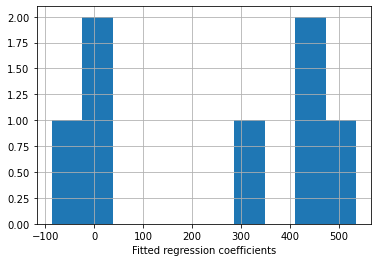

In [30]:
impact = pd.DataFrame(coefs).T
impact.columns = ['slope', 'intercept']
impact['slope'].hist(bins=10)
plt.xlabel('Fitted regression coefficients')

Text(0, 0.5, 'average duration')

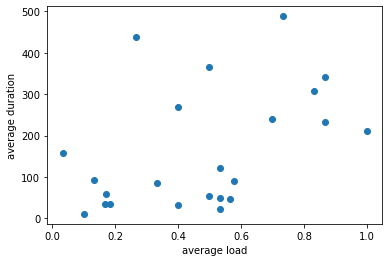

In [27]:
y = totalplot.groupby('interval')['duration'].mean()
x = totalplot.groupby('interval')['count'].mean()
plt.scatter(x,y)
plt.xlabel('average load')
plt.ylabel('average duration')

In [ ]:
queue = pd.DataFrame(total[~total['segment_name'].isin(working_segments)].groupby(['resource', 'interval'])['count'].sum())
queue.reset_index(inplace=True)
queue

In [ ]:
rf.pf['load'] = rf.pf['start_interval'].map(load.groupby('interval')['count'].sum())
rf.pf['queue'] = rf.pf['start_interval'].map(queue.groupby('interval')['count'].sum())

In [ ]:
y = rf.pf.groupby('load')['duration'].mean()
x = rf.pf.groupby('load')['duration'].mean().index
plt.scatter(x,y)
plt.xlabel('average load')
plt.ylabel('average duration')

In [ ]:
rf.pf[rf.pf['segment_name'] == 'Create Fine-Send Fine'].groupby('start_interval')['duration'].mean().plot()

In [ ]:
load['date'] = load['interval'].apply(lambda x: rf.first + datetime.timedelta(days=30*x))
queue['date'] = queue['interval'].apply(lambda x: rf.first + datetime.timedelta(days=30*x))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])
load.groupby('date')['count'].sum().plot(ax=ax[0])
ax[0].set_xlim(min(load['date']), load['date'][570])
ax[0].set_ylabel('Average workload across all resources')
ax[0].set_xlabel('Month-long interval')
queue.groupby('date')['count'].sum().plot(ax=ax[1])
ax[1].set_xlim(min(load['date']), load['date'][570])
ax[1].set_ylabel('Average queuelength across all resources')
ax[1].set_xlabel('Month-long interval')

In [ ]:
rf.pf['date_end'] = rf.pf['end_time'].apply(lambda x: rf.first + datetime.timedelta(days=x))
rf.pf['date_start'] = rf.pf['predicted_start'].apply(lambda x: rf.first + datetime.timedelta(days=x))
date = dict(rf.pf.groupby(['end_interval']).first()['date_end'])
labs = {d*30:str(date[d]).split('T')[0] for d in date if d%12 == 0}

In [ ]:
class_colors = [(69/256, 117/256, 180/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[40,40])
rf.plot_performance_spectrum(class_colors, ax, label_offset=500, start='predicted_start', mask=(rf.pf['load'] > 20), vis_mask=True, exclude=(rf.pf['date_end'] > datetime.datetime(2008, 1,1)) | (rf.pf['date_start'] < datetime.datetime(2003, 1,1)))
ax.set_xticks([i for i in labs.keys() if i < ax.get_xlim()[1] and i > ax.get_xlim()[0]])
ax.set_xticklabels(list(labs.values()));

# Caculate workload and queeulength

In [17]:
rf.pf['end_interval'] = rf.pf['end_time'] // 7
rf.pf['start_interval'] = rf.pf['predicted_start'] // 7
intervals = rf.pf['start_interval'].unique()
segments = [s for s in rf.segments if '-' not in s]
que_total = {s:{} for s in segments}
load_total = {s:{} for s in segments}

for interval in intervals:
    cases = rf.pf[((rf.pf['start_interval'] <= interval) & (rf.pf['end_interval'] >= interval+1)) | ((rf.pf['start_interval'] == interval) & (interval == rf.pf['end_interval']))]
    for segment in segments:
        que = dict(cases[(cases['shelve'] == True) & (cases['segment_end'] == segment)]['resource_end'].value_counts())
        load = dict(cases[(cases['segment_name'] == segment) & (cases['shelve'] != True)]['resource'].value_counts())
        que_total[segment][interval] = que
        load_total[segment][interval] = load

que_df = pd.DataFrame(que_total[list(que_total.keys())[0]]).T.sort_index().fillna(0)
for segment in list(que_total.keys())[1:]:
    temp = pd.DataFrame(que_total[segment]).T.sort_index().fillna(0)
    for resource in temp.columns:
        if resource in que_df.columns:
            que_df[resource] += temp[resource]
        else:
            que_df[resource] = temp[resource]
            
load_df = pd.DataFrame(load_total[list(load_total.keys())[0]]).T.sort_index().fillna(0)
for segment in list(load_total.keys())[1:]:
    temp = pd.DataFrame(load_total[segment]).T.sort_index().fillna(0)
    for resource in temp.columns:
        if resource in load_df.columns:
            load_df[resource] += temp[resource]
        else:
            load_df[resource] = temp[resource]

active = ((load_df > 0) & (load_df >= load_df.mean())).sum(axis=1)
duration = rf.pf.groupby('start_interval')['duration'].mean().rolling(7).mean()

In [18]:
load_df['working_in_segment'] = rf.pf[rf.pf['segment_name'] == 'Insert Fine Notification'].groupby('start_interval')['resource'].unique()
load_df['load'] = load_df.index.map({y:load_df[x].iloc[y].sum() for y,x in enumerate(load_df['working_in_segment']) if x is not np.nan})
que_df['working_in_segment'] = rf.pf[rf.pf['segment_name'] == 'Insert Fine Notification'].groupby('start_interval')['resource'].unique()
que_df['que'] = que_df.index.map({y:que_df[x].iloc[y].sum() for y,x in enumerate(que_df['working_in_segment']) if x is not np.nan})

In [19]:
breaks = jenkspy.jenks_breaks(que_df['que'], nb_class=4)
breaks = [[breaks[i], breaks[i+1]] for i in range(len(breaks)-1)]
classed = [list(que_df[(que_df['que'] >= x) & (que_df['que'] < y)].index) for x,y in breaks]
for i,todo in enumerate(classed):
    for c in todo:
        que_df.loc[c, 'que_class'] = i
que_df['que_class'] = que_df['que_class'].fillna(0)
rf.pf['que_class'] = list(que_df.loc[rf.pf['start_interval']]['que_class'])
que_breaks = breaks

c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\jenkspy\core.py:64: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')


In [20]:
breaks = jenkspy.jenks_breaks(load_df['load'], nb_class=4)
breaks = [[breaks[i], breaks[i+1]] for i in range(len(breaks)-1)]
classed = [list(load_df[(load_df['load'] >= x) & (load_df['load'] < y)].index) for x,y in breaks]
for i,todo in enumerate(classed):
    for c in todo:
        load_df.loc[c, 'load_class'] = i
load_df['load_class'] = load_df['load_class'].fillna(0)
rf.pf['load_class'] = list(load_df.loc[rf.pf['start_interval']]['load_class'])
load_breaks = breaks

Text(0.5, 0, 'natural break')

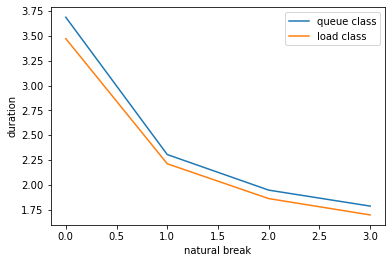

In [21]:
plot = rf.pf[rf.pf['segment_name'] == 'Insert Fine Notification'].groupby('que_class')['duration'].mean()
plot = pd.concat([plot, rf.pf[rf.pf['segment_name'] == 'Insert Fine Notification'].groupby('load_class')['duration'].mean()], axis=1)
plot.columns = ['queue class', 'load class']
plot.plot()
plt.ylabel('duration')
plt.xlabel('natural break')

# Upgraded colors performance spectrum

In [24]:
color_scale = cl.scales['10']['div']['Spectral']
color_scale = list(reversed([[k/256 for k in ast.literal_eval(i.replace('rgb', ''))] for i in color_scale]))

mapper = {row['case_id']: row['que_class'] for ind, row in rf.pf[rf.pf['segment_name'] == 'Insert Fine Notification'][['case_id', 'que_class']].iterrows()}
rf.pf['global que_class'] = rf.pf['case_id'].map(mapper)

mapper = {row['case_id']: row['load_class'] for ind, row in rf.pf[rf.pf['segment_name'] == 'Insert Fine Notification'][['case_id', 'load_class']].iterrows()}
rf.pf['global load_class'] = rf.pf['case_id'].map(mapper)

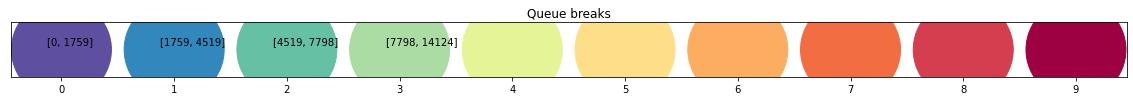

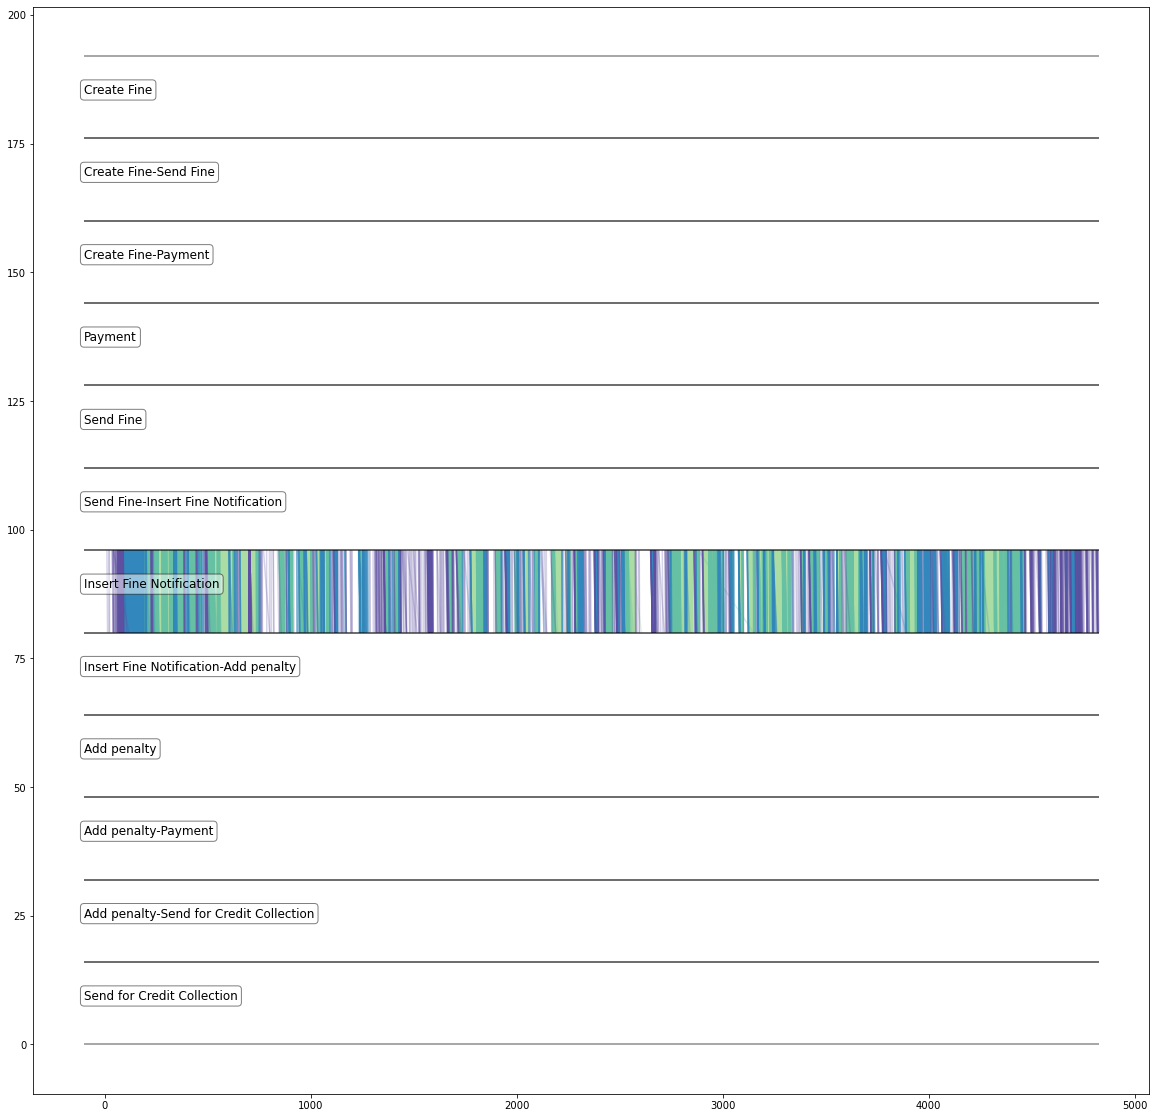

In [25]:
x = [i for i in range(len(color_scale))]
y = [0 for i in range(len(color_scale))]
fig, ax = plt.subplots(figsize=[20,1])
ax.scatter(x, y, c=color_scale, s=10000)
for i, txt in enumerate(que_breaks):
    ax.annotate([int(i) for i in txt], (x[i]-0.125, y[i]+0.01))
ax.set_xticks(x)
ax.set_yticks([])
plt.title('Queue breaks')

class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]

# rf.classify(rf.pf, rf.classify_duration_hist,  'duration', [4], inplace=True)
rf.pf['class'] = rf.pf['global que_class']
fig, ax = plt.subplots(figsize=[20,20])
rf.plot_performance_spectrum(color_scale, ax, start='predicted_start',mask=(rf.pf['segment_name'] == 'Insert Fine Notification'), label_offset=-100)

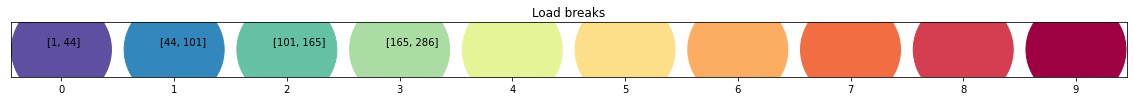

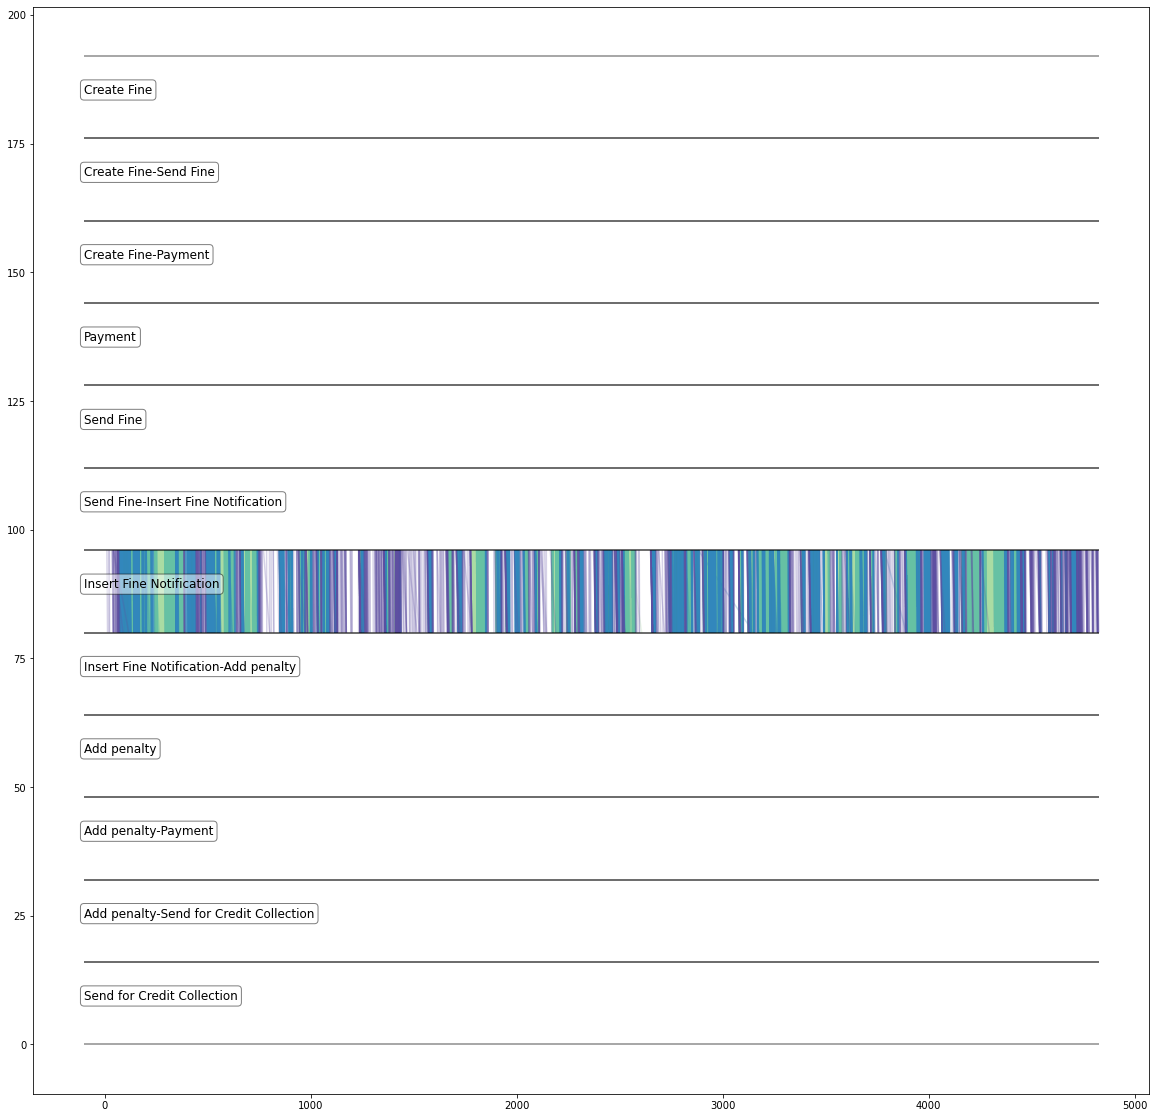

In [26]:
x = [i for i in range(len(color_scale))]
y = [0 for i in range(len(color_scale))]
fig, ax = plt.subplots(figsize=[20,1])
ax.scatter(x, y, c=color_scale, s=10000)
for i, txt in enumerate(load_breaks):
    ax.annotate([int(i) for i in txt], (x[i]-0.125, y[i]+0.01))
ax.set_xticks(x)
ax.set_yticks([])
plt.title('Load breaks')

class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]

# rf.classify(rf.pf, rf.classify_duration_hist,  'duration', [4], inplace=True)
rf.pf['class'] = rf.pf['global load_class']
fig, ax = plt.subplots(figsize=[20,20])
rf.plot_performance_spectrum(color_scale, ax, start='predicted_start',mask=(rf.pf['segment_name'] == 'Insert Fine Notification'), label_offset=-100)

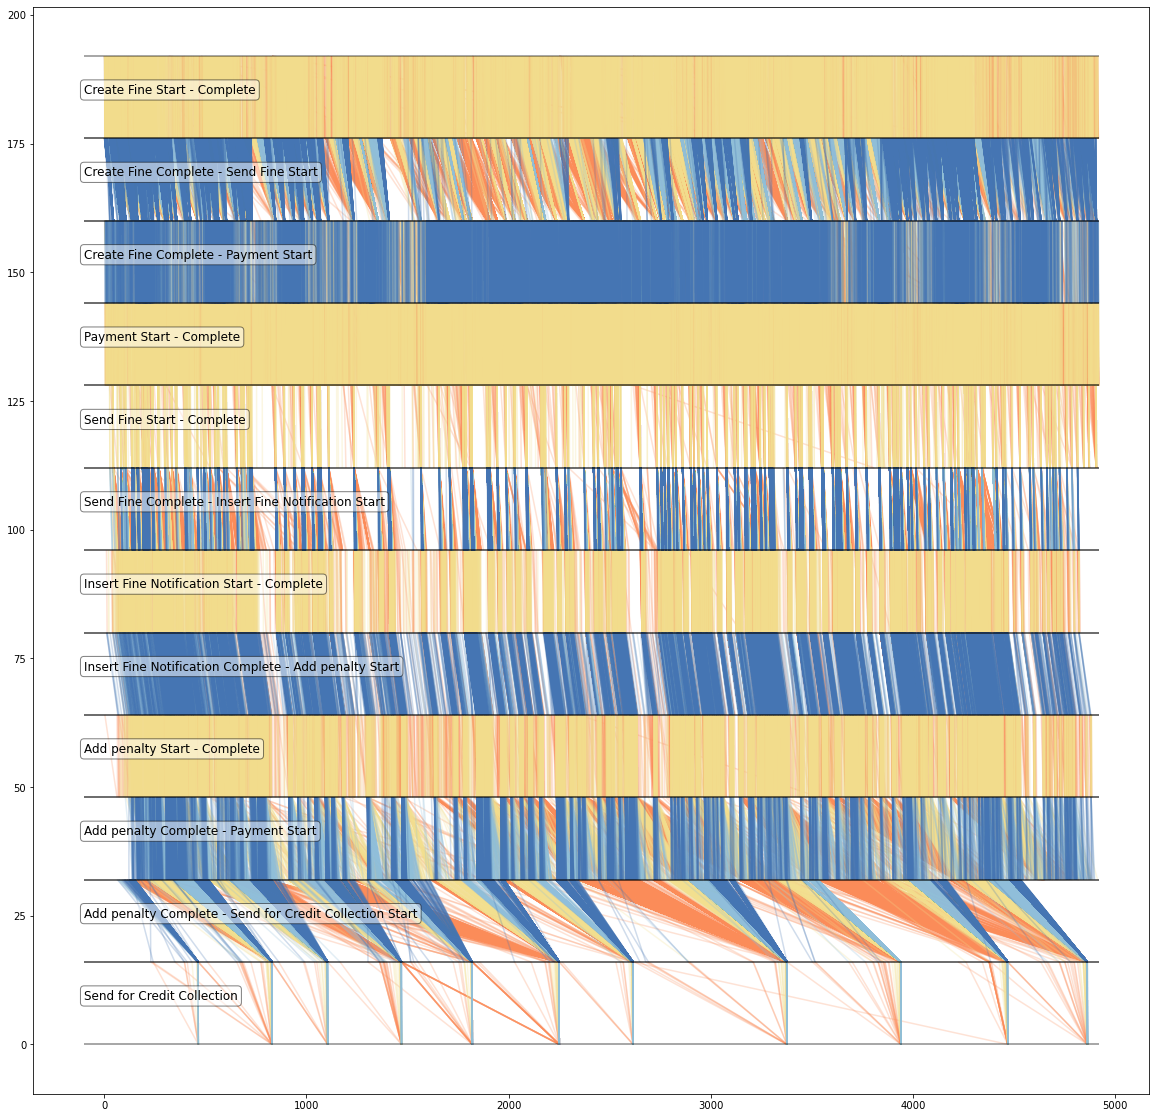

In [113]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
rf.classify(rf.pf, rf.classify_duration_hist,  'duration', [4], inplace=True)
fig, ax = plt.subplots(figsize=[20,20])
rf.plot_performance_spectrum(class_colors, ax, start='predicted_start',  label_offset=-100)

In [30]:
rf.pf.to_csv('C:/Users/20173939/Documents/Study/BEP/roadfines.txt')